In [3]:
# import modules
import os 
import sys
from qutip import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib

# locate directory containing scripts 
current_directory = os.getcwd() 
src_directory = os.path.dirname(current_directory) + '/src'
sys.path.append(src_directory)


# import custom module
import spin_chain
importlib.reload(spin_chain)

# define identity for qubits 
I2 = qeye(2)

# define Pauli matrices and constants
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()
π = np.pi

# font specs for plots
%matplotlib inline
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.size"] = "14"

In [12]:
# collect data for 2-site spin chain
N_qubits = 2
Jx = 1
Jy = 1
Jz = 1
periodic_bc = False
tolerance2 = 1e-12
H2, H2_list, eigenstates2, eigenvalues2, min_eigenvalue2, ρ_ground_state2 = \
spin_chain.properties(N_qubits,Jx,Jy,Jz, periodic_bc, tolerance2)
spin_chain.orthonormal_eigenstates(eigenstates2, tolerance2)

Your eigenstates form an orthonormal basis!


In [13]:
def Dxyz(projected_cavities, α, λ, E_n, cutoff):
    
    """
    displacement operator that displaces 1 or 2 cavities by 2-site Hamiltonian
    """
    
    # define annihilation operator according to Fock space
    a = destroy(cutoff)
    Ib = qeye(cutoff)
        
    # determine which cavities to displace
    if projected_cavities == 1: 
        cavity_subsystem = tensor([α*a.dag() - np.conj(α)*a, Ib])
    if projected_cavities == 2: 
        cavity_subsystem = tensor([α*a.dag() - np.conj(α)*a, Ib]) + tensor([Ib, α*a.dag() - np.conj(α)*a])

    # define Hamiltonian of two-site spin chain 
    qubit_subsystem = tensor(σ_x, σ_x) + tensor(σ_y, σ_y) + λ*tensor(σ_z, σ_z) - E_n*tensor(I2, I2)

    return (tensor(cavity_subsystem, qubit_subsystem)).expm()
def ground_state_projection(N_cavities, N_qubits, m_start, m_stop, α_start, α_end, α_steps, \
                            λ, E_n, initial_state_list, cutoff):
    
    '''
    simulates ground state projection algorithm, allowing user to specify the number of cavities 
    to project onto vacuum, the range of α to sweep, how many states to simulate, etc. 
    '''

    # define operators for bosonic modes 
    a = destroy(cutoff)
    Ib = identity(cutoff)

    # define vacuum state for a cavity, and spin up and spin down states for qubits
    vacuum = basis(cutoff, 0)
    up = basis(2,0)
    down = basis(2,1)

    # define projection operators that project the one or two cavities onto the vacuum
    P = tensor(vacuum*vacuum.dag(), vacuum*vacuum.dag(), I2, I2)

    # define list of the number of cavities that we will project onto vacuum
    if m_start >= 1 and m_stop <= N_cavities: 
        cavity_list = list(range(m_start, m_stop+1))
    else: 
        print("Enter valid list of cavities to project")

    # define array over which we will sweep α
    α_array = np.linspace(α_start, α_end, α_steps)

    # calcuate overlap with the singlet after displacement
    fidelity_array_list = [[[fidelity(ρ_ground_state2, \
                                    ((P*Dxyz(m, α, λ, E_n, cutoff)*initial_state) \
                                     .unit()).ptrace([2,3]))**2 \
                                     for α in α_array] \
                                     for m in cavity_list] \
                                     for initial_state in initial_state_list]

    # Generate unique colors using the 'tab10' color map
    colors = ['blue', 'orange', 'green','red', 'purple', 'black', 'pink', 'gray', 'cyan', 'magenta']

    # generate custom linestyles to use if we are projecting 4 or more cavities onto vacuum
    dashed_list = [(None, None), (5, 2), (1, 2), (5, 2, 1, 2), (10, 5, 2, 5), \
                   (2, 2, 10, 2), (5, 2, 10, 2, 5, 2), (15, 5, 5, 5), (2, 5, 10, 5)]

    # create plot with axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # graph the theoretical projection of all initial states onto the true ground state 
    for i in range(len(fidelity_array_list)): # loop for all initial_states
        for j, fidelity_array in enumerate(fidelity_array_list[i]): # loop for α_array
            ax.plot(α_array, fidelity_array, \
                    label=f'Cavities =  {cavity_list[j]}, $F_0$ = {fidelity_array[0] :.3f}', \
                    color=colors[i], linestyle='-', dashes = dashed_list[(len(cavity_list) - 1) - j])

        ax.set_xlabel(r'$\alpha$', fontsize=15)
        ax.set_ylabel('Fidelity', fontsize=15)
        ax.set_title(f'Simulated GSP with N = {N_qubits}', fontsize=17.5) 
        ax.legend(fontsize = 12.5)
        ax.grid(True) 
        
    if save_file: 
        
        # define which folder subfolder in /data to store the image
        if N_qubits == 2: 
            site_folder = 'two_sites'
        elif N_qubits == 3: 
            site_folder = 'three_sites'
        elif N_qubits == 4: 
            site_folder = 'four_sites'
        elif N_qubits == 5: 
            site_folder = 'five_sites'

        # calculate number of states that were simulated
        num_states = len(initial_state_list)

        if m_start != m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f'{num_states}_{m_start}{m_stop}.png'

            # Check if the file already exists
            if os.path.exists(filename):
                # If it exists, remove it
                os.remove(filename)

            # save figure 
            plt.savefig(filename)

        elif m_start == m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f'{num_states}_{m_start}.png'

            # Check if the file already exists
            if os.path.exists(filename):
                # If it exists, remove it
                os.remove(filename) 

            # save figure 
            plt.savefig(filename)

In [14]:
N_qubits = 2
N_cavities = 2
m_start = 1
m_stop = 2
α_start = 0
α_end = 1
α_steps = 100
λ = 1
E_n = -3
cutoff = 12
num_states = 4
save_file = False
initial_state_list = spin_chain.generate_initial_states(N_cavities, N_qubits, num_states, cutoff)

AttributeError: module 'spin_chain' has no attribute 'generate_initial_states'

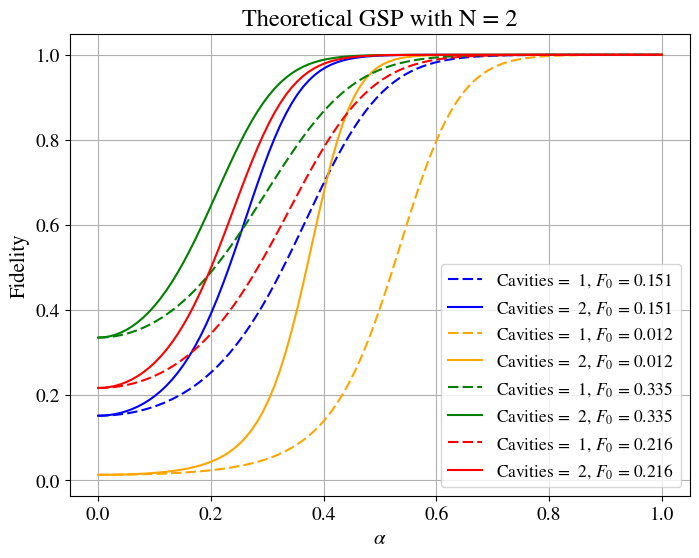

In [9]:
spin_chain.plot_fidelity(N_cavities, N_qubits, eigenvalues2, eigenstates2, m_start, m_stop, \
              α_start, α_end, α_steps, initial_state_list, cutoff, save_file)

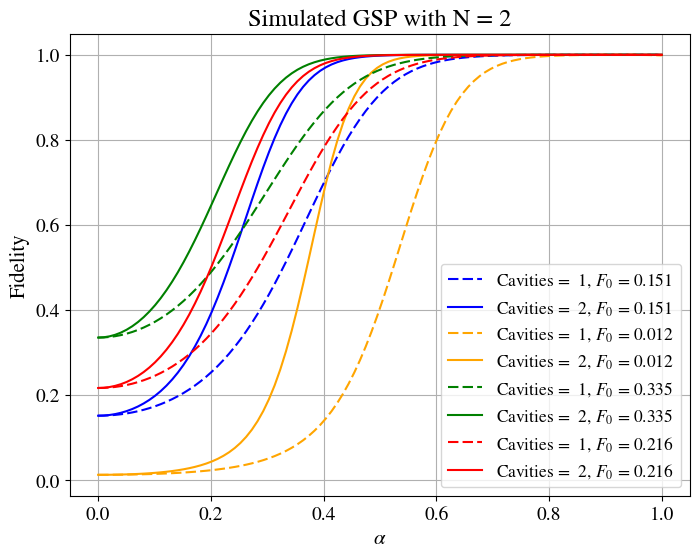

In [10]:
ground_state_projection(N_cavities, N_qubits, m_start, m_stop, α_start, α_end, α_steps, \
                        λ, E_n, initial_state_list, cutoff)